# FINM 33150 Quantitative Trading Strartegies
Homework-4 Submitted by Vidhan Ajmera\
Email: vidhanajmera@uchicago.edu
## Accumulation Opportunity
### Sections
1. Objectives
2. Helper Functions
3. Exploratory Data Analysis
4. Single Strategy VWAP Simulator
5. Sensitivity and Comparative Analysis 
6. Drawbacks & Path Forward

## 0. Motivation
"Innovation, excessive speculation, and dubious behavior are often closely linked." A defining quote fits perfectly the context of explaining tke highlights of this assignment. Cryptocurrencies have grown from nearly nothing to over <b>$1.5 trillion </b>in market capitalization in a span of 5 years, and it is still growing. And so is the interest of market participants, corresponding volume, derivative products and portfolio allocation of crypto-assets in the world of finance. What is unique about crypto market is that  it is a volatile market <b> by design. </b> \
So how can we build a <b> algorithmic trading strategy </b> to exploit this inherent volatility and growing volume? What market forces are at play when we want to take large positions crypto assets? What parameters are worth considering when placing a large order in such markets? What signal can we generate from large orders that can help us reduce our transaction cost? We will try to find answers to these questions, in detail, and summarize the behavior of crypto markets based on past 3 years of high frequency data. 

## 1. Objective
The objective of this excercise is to assess the feasibility of accumulating large positions while attempting to maintain low trading costs in an electronic market.
We consider high frequency data for 3 pairs of instruments:\
    1. BTC/USD\
    2. ETH/USD\
    3. ETH/BTC\
In this assignment, we will use high frequency data for 3 different time-frames in the years 2021,2022 and 2023, to generate a comparative analysis of all the performance metrics and input parameters crucial to price movements occuring in a small fraction of time. Following are the definitions of input parameters:

<b>Arrival Time</b> is the time where we enter the order book and get the first full/part of our order filled. Although, it may not be every relevant for small size trades, but for accumulation trades, this is important to understand as to where we start as a price point and where we land-up as our average cost/price for buy/sell order.\
<b>Position Size</b> is an important decision maker in any crypto market. Orders with small size tend to be executed at the market price(bid/ask) and have negligible impact on the price. On the contrary, large orders tend to move the price away from the starting point and push the average price against the buyer/seller.\
<b>Chunk size </b> is the increment in total market volume in which increases in target participation are determined. In this excercise, we set chunk size based on a target number of steps over a 15 minute interval.\
<b>Target participation rate</b> is a measure of the speed of trading relative to the available liquidity in the marketplace. Identifying the correct participation rate is the key to solving the trading puzzle known as the “Traders Dilemma”. The Trader’s dilemma is all about the velocity of trading. If we trade too fast, we will incur price impact. We will be responsible for increasing the price that we must pay for the stock and so increase our trading costs. On the other hand, if we trade too slowly, we risk the opportunity cost of missing better priced liquidity. We wind up having to pay higher prices if the market moves away from me and also incur higher trading costs.\
<b>Tranasction costs</b> in crypto trading refer to the fees charged for buying, selling, or exchanging cryptocurrencies. Specifically, trading fees, which are charged by the exchange for executing a trade and calculated as a percentage of the trade's total value, have important contribution to the PnL in a strategy. With higher number of trades, trading cost could cut down our returns substantially.

## 2. Helper Functions
This section includes the import of relevant libraries and defining the functions for fetching, generating, plotting and analyzing the time-series.\
I have used caching for storing the data fetched from Canvas Folder.

In [486]:
import os
import random
import numpy as np
import pandas as pd
import nasdaqdatalink
import scipy.stats as ss
import seaborn as sns
from functools import lru_cache
import plotnine as p9
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import display
import datetime as dt
import pandas_datareader as pdr
import warnings
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [15,10]
warnings.filterwarnings('ignore')

In [2]:
def format_my_nanos(nanos):
    '''
    -function for converting nano-second epoch to date-time string
    -input the int form of time stamp
    '''
    dt1 = dt.datetime.fromtimestamp(nanos / 1e9)
    return '{}.{:09.0f}'.format(dt1.strftime('%Y-%m-%dT%H:%M:%S'), nanos % 1e9)

In [3]:
def get_data(dir_name,filename):
    '''
    -This function helps in importing delim.gz extension files from local drive.
    dir_name is the location of folder where the files are kept
    Filname is a list of names that one wishes to load.
    '''
    all_books=[]
    for i,file in enumerate(filename):
        df=pd.read_csv(dir_name+file+'.delim.gz', delimiter='\t', compression='gzip')
        all_books.append(df)
    z=tuple(all_books)
    return z

In [234]:
def simulate_vwap(df,Q,p,start_time,fees=0, side):
    '''
    This function simulates a simple VWAP price for any order quantity that needs to be filled
    and does so based on following inputs:
    1. df: historical database for trades that occured.
    2. Q: quantity of asset that needs accumulation (in billionths)
    3. p: participation rate, which is the portion of size that can be bought/sold without
    much impacting the price
    4. start time: time at which we need to start taking positions
    5. fees: Transaction fees( 0.05 for BTC/USD and ETH/USD, while .01 for crypto/crypto)
    6. Side: type of order
    '''
    data=df.copy()
    data['Side']=np.where(meta_data[0]['Side']>0,1,-1)
    data.drop(['received_utc_nanoseconds'],axis=1,inplace=True)
    data['PriceMillionths']=data['PriceMillionths']/10e5
    data['SizeBillionths']=data['SizeBillionths']/10e8
    if side=='buy':
        data=data[data['Side']==1]
        timefmt = '%Y-%m-%dT%H:%M:%S'
        data['Date'] = pd.to_datetime(data['timestamp_utc_nanoseconds'], format=timefmt)
        data['Date']=data['Date'].dt.round(".1S")
        data=data.groupby("Date",).agg({'timestamp_utc_nanoseconds':lambda x: x.iloc[-1],'PriceMillionths':'max','SizeBillionths':lambda x: x.iloc[-1],'Side':lambda x: x.iloc[-1]})
        data['volume_traded']=0
        data['cum_trans_cost']=0
        data['curr_vwap']=0
        data.reset_index(inplace=True)
        data=data[data['timestamp_utc_nanoseconds']>=start_time]
        data.reset_index(inplace=True)
        for i in range(len(data.index)):
            if Q>0:
                data.iloc[i,6]=min(p*data.iloc[i,4],Q)
                Q=Q-data.iloc[i,6]                
                if i==0:
                    data.iloc[i,7]=(data.iloc[i,3]*data.iloc[i,6])
                    data.iloc[i,8]=(data.iloc[i,3]*data.iloc[i,6])
                else:
                    data.iloc[i,7]=data.iloc[i-1,7]+(data.iloc[i,3]*data.iloc[i,6]*(1+fees))
            else:
                break;
        return data[data['cum_trans_cost']>0]
            
    else:
        data=data[data['Side']==-1]
        timefmt = '%Y-%m-%dT%H:%M:%S'
        data['Date'] = pd.to_datetime(data['timestamp_utc_nanoseconds'], format=timefmt)
        data['Date']=data['Date'].dt.round(".1S")
        data=data.groupby("Date").agg({'timestamp_utc_nanoseconds':lambda x: x.iloc[-1],'PriceMillionths':'min','SizeBillionths':lambda x: x.iloc[-1],'Side':lambda x: x.iloc[-1]})
        data['volume_traded']=0
        data['cum_trans_cost']=0
        data.reset_index(inplace=True)
        data=data[data['timestamp_utc_nanoseconds']>=start_time]
        data.reset_index(inplace=True)
        for i in range(len(data.index)):
            if Q>0:
                data.iloc[i,6]=min(p*data.iloc[i,4],Q)
                Q=Q-data.iloc[i,6]                
                if i==0:
                    data.iloc[i,7]=(data.iloc[i,3]*data.iloc[i,6])
                else:
                    data.iloc[i,7]=data.iloc[i-1,7]+(data.iloc[i,3]*data.iloc[i,6]*(1+fees))
            else:
                break;
        return data[data['cum_trans_cost']>0] 
    

In [298]:
def price_summary(df,y):
    '''
    This function provides a comparision of various market price estimates
    '''
    VWAP=round((df['PriceMillionths']*df['SizeBillionths']).sum()/df['SizeBillionths'].sum(),2)
    tp=round(df.iloc[-1,7]/df['volume_traded'].sum(),0)
    ip=round(df.iloc[0,3],2)
    temp = pd.DataFrame(dtype='int64',index=['TWAP','VWAP','Initial Price','Transaction Price','Implementation Shortfall'])
    temp[f'{y} prices per unit qty'] = [round(df['PriceMillionths'].mean(),2),VWAP,ip,tp,tp-ip]
    return temp

In [324]:
def plot_prices(dfx,pair,start=None,finish=None,extension = ''):
    
    '''
    This function currency pair prices at each traded data point.
    OPTIONAL: plot series start, end and title descriptions
    '''
    df = dfx.drop(columns='timestamp_utc_nanoseconds').set_index('received_utc_nanoseconds').sort_index()
    df.index = pd.to_datetime(df.index)
    if start and finish:
        df = df[start:finish]
    df = df[['PriceMillionths']]
    df['returns'] = df.pct_change()
    df = df.dropna()
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 6))
    ax1.plot(df['PriceMillionths'],color = 'black') 
    ax1.tick_params(labelrotation=45)
    ax1.set_title(pair+" Price",fontsize = 10)
    ax1.set_ylabel(pair+' Price',fontsize = 10)
    ax1.set_xlabel('GMT',fontsize = 10)
    ax1.grid(linestyle='solid', linewidth=0.5)
    ax2.plot(df['returns'].cumsum(),color = 'darkcyan') 
    ax2.tick_params(labelrotation=45)
    ax2.set_title(pair+" Returns",fontsize = 10)
    ax2.set_ylabel(pair+' Returns',fontsize = 10)
    ax2.set_xlabel('GMT',fontsize = 10)
    ax2.grid(linestyle='solid', linewidth=.5)
    plt.suptitle(pair+' Price and Returns for the year '+extension,fontsize=14) 
    plt.tight_layout()
    plt.show()

In [ ]:
def scale_df_15min(df):
    '''
    Scales dataframe to 15 min time window
    '''
    df_15min=df.copy()
    df_15min['Side']=np.where(df_15min['Side']>0,1,-1)
    df_15min.drop(['received_utc_nanoseconds'],axis=1,inplace=True)
    df_15min['PriceMillionths']=df_15min['PriceMillionths']/10e5
    df_15min['SizeBillionths']=df_15min['SizeBillionths']/10e8
    df_15min.timestamp_utc_nanoseconds = pd.to_datetime(df_15min.timestamp_utc_nanoseconds)
    df_15min.set_index("timestamp_utc_nanoseconds",inplace=True)
    df_15min = df_15min.groupby("Side").resample("15min").sum()[["PriceMillionths","SizeBillionths"]]
    df_15min = df_15min.reset_index()
    df_15min.SizeBillionths = df_15min.SizeBillionths * df_15min.Side
    df_15min = df_15min.sort_values(["Side", "timestamp_utc_nanoseconds"], ascending=[True, True])
    return df_15min

In [194]:
def summaryStats(df1):
    '''
    This function provides summary of all prices from trading algorithm
    '''
    df=df1.pct_change()
    summary = pd.DataFrame(index = df.columns)
    summary['Period Return'] = df.mean()*len(df)
    summary['Volatility'] = df.std()*np.sqrt(len(df))
    summary['Sharpe Ratio'] = summary['Period Return']/summary['Volatility']    
    summary['Skewness'] = df.skew()
    summary['Expected Shortfall (95% VaR)'] = df[df < df.quantile(0.05)].mean()
    levels = (1+df).cumprod()
    high = levels.cummax()
    drawdown = (levels - high)/high
    summary['Maximum Drawdown'] = drawdown.min()
    return summary

In [32]:
def heatmap(data, title):
    '''
    This function helps in generating the correlation between various assets
    '''
    corr_matrix = data.corr()
    plt.figure(figsize=(12,8))
    heat_map = sns.heatmap(corr_matrix, linewidth = 1 , annot = True)
    plt.title(f"{title}")
    plt.show()

In [ ]:
def plot_price_volume(df):
    '''
    Plots price and volume in same graph
    '''
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('GTC')
    ax1.set_ylabel(f'Price of {asset[0]}', color=color)
    ax1.plot(df['timestamp'], df['price'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Volume', color=color)  # we already handled the x-label with ax1
    ax2.bar(df['timestamp'], df['volume'], color=color, alpha=0.5)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

In [450]:
def plot_side_vwaps(df,signal):
    
    '''
    Plots VWAP price with volume and current price
    '''
    vwap=simulate_vwap(df,500,.05,df.iloc[10,0],fees=0, side=signal)
    vwap['curr_vwap']=vwap['PriceMillionths']*vwap['SizeBillionths']
    vwap['curr_vwap']=vwap['curr_vwap'].cumsum()
    vwap['cumm_vv']=vwap['SizeBillionths'].cumsum()
    vwap['curr_vwap']=vwap['curr_vwap']/vwap['cumm_vv']
    fig, ax = plt.subplots(figsize = (15, 8))
    ax2 = ax.twinx()
    ax.plot(vwap['curr_vwap'], label = "VWAP", color='Black')
    ax.plot(vwap['PriceMillionths'], label = "Transaction Price", color='orange' )
    ax.set_xlabel('GTC')
    ax.set_ylabel('Price in $',fontsize = 12)
    ax.legend(fontsize = 12)
    ax2.plot( vwap['SizeBillionths'],label = "Volume", color='darkcyan')
    ax2.set_ylabel('Volume',fontsize = 12)
    plt.grid(True)
    plt.title(f'BTC/USD 2023 VWAP trend with price and volume for {signal} side', fontsize=15)
    plt.tight_layout()
    plt.show()

In [466]:
def distribution_var(data):
    '''
    gives the distribution of variables
    '''
    plt.figure(figsize=(14,10))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    colors = ['crimson', 'darkcyan', 'mediumseagreen', 'violet']
    for i, col in enumerate(data.index):
        plt.subplot(2, 2, i+1)
        sns.distplot(data[col], color=colors[i], label=col)
        plt.legend()
        plt.title(f"Distribution of {col}")
    plt.show()
    plt.close()

## 3. Exploratory Data Analysis

<b> 3.1 Data Import from Canvas folder </b>

In [8]:
dir_name='/Users/vidhanajmera/Desktop/Winter 2023/QTS/Homework-4/Data/'
filename = ['trades_narrow_BTC-USD_2023','trades_narrow_ETH-USD_2023','trades_narrow_ETH-BTC_2023',\
            'trades_narrow_BTC-USD_2022','trades_narrow_BTC-USD_2022','trades_narrow_BTC-USD_2022',\
            'trades_narrow_BTC-USD_2021','trades_narrow_BTC-USD_2021','trades_narrow_BTC-USD_2021',]
meta_data = get_data(dir_name,filename)

In [67]:
#BTC/USD data
assets=['BTC/USD','ETH/USD','ETH/BTC']
for i in range(3):
    print(f"Price and Volume range for {assets[i]} from year 2023 data")
    print(f"{meta_data[i].describe()[['PriceMillionths','SizeBillionths']]}\n")

Price and Volume range for BTC/USD from year 2023 data
       PriceMillionths  SizeBillionths
count     5.601070e+05    5.601070e+05
mean      2.284198e+10    7.164636e+07
std       1.924850e+08    1.825450e+08
min       2.233862e+10    1.000000e+01
25%       2.266548e+10    2.118340e+06
50%       2.289284e+10    1.227433e+07
75%       2.299966e+10    7.416834e+07
max       2.316556e+10    2.744100e+10

Price and Volume range for ETH/USD from year 2023 data
       PriceMillionths  SizeBillionths
count     3.771850e+05    3.771850e+05
mean      1.588622e+09    6.345828e+08
std       3.784650e+07    2.186991e+09
min       1.532690e+09    1.000000e+01
25%       1.550280e+09    3.081824e+07
50%       1.611270e+09    1.573535e+08
75%       1.622030e+09    5.547343e+08
max       1.640540e+09    3.403621e+11

Price and Volume range for ETH/BTC from year 2023 data
       PriceMillionths  SizeBillionths
count      1958.000000    1.958000e+03
mean      69643.549540    8.951463e+08
std        111

From the time-series data analysis of the 2023 tick data, we can conclude following points:

-A total of 40,129 Bitcoins and 2,39,355 Ethereum coins were traded over the 2 and a half day period.\
-A total of 5,60,107 trades were executeded BTC/USD market and 3,77,185 trades were executed in ETH/USD market.\
-Volatility in Bitcoin is higher than Ethereum.



In [68]:
print(f" Number of Nan values in BTC/USD data series: {meta_data[0].isnull().sum().sum()}")

 Number of Nan values in BTC/USD data series: 0


In [69]:
print(f" Number of duplicate values in timestamp in BTC/USD data series: {meta_data[0].timestamp_utc_nanoseconds.nunique()}")

 Number of duplicate values in timestamp in BTC/USD data series: 369484


<b> Observation </b> As can be seen from the result above, their are no missing values, but their are duplicates w.r.t. the time stamp, which could have happened because of delay in recording the trade or "clock skew".

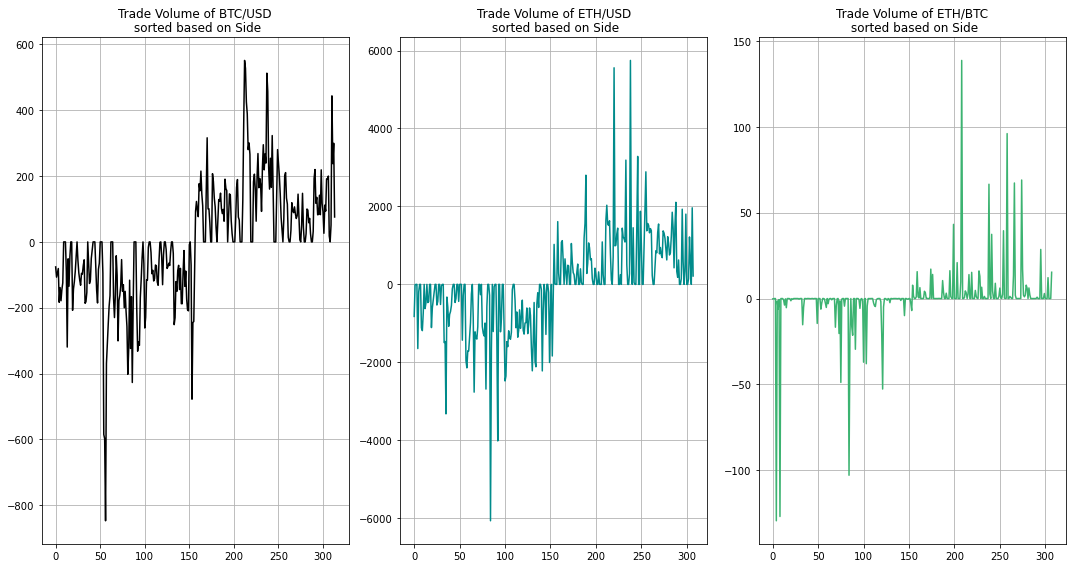

In [216]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))
for i in range(3):    
    df_1min=scale_df_15min(meta_data[i])
    colors = [ 'black','darkcyan','mediumseagreen']
    axs[i].plot(df_1min['SizeBillionths'], color=colors[i])
    axs[i].set_title(f'Trade Volume of {assets[i]}\n sorted based on Side',fontsize=12)
    axs[i].grid(True)
plt.tight_layout()
plt.show()

<b> Observation </b> Here we see that there is a fair amount of variability in volume changes with both buy and sell side. The other thing we notice is that the trading history is not continuous, meaning there are gaps. This will add noise to our test cases that measure implementation shortfall and time duration from randomly chosen arrival times.

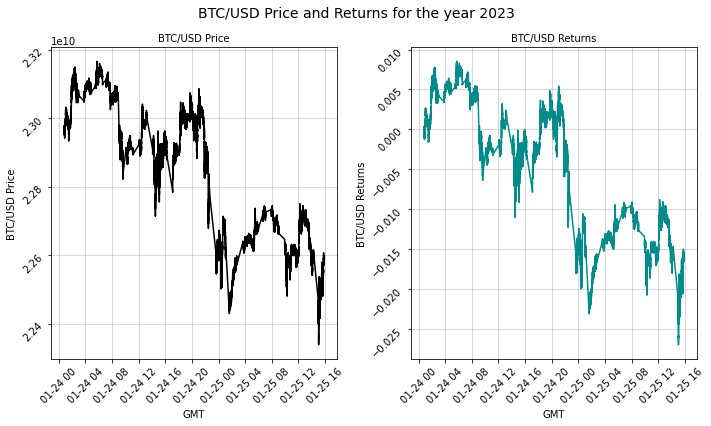

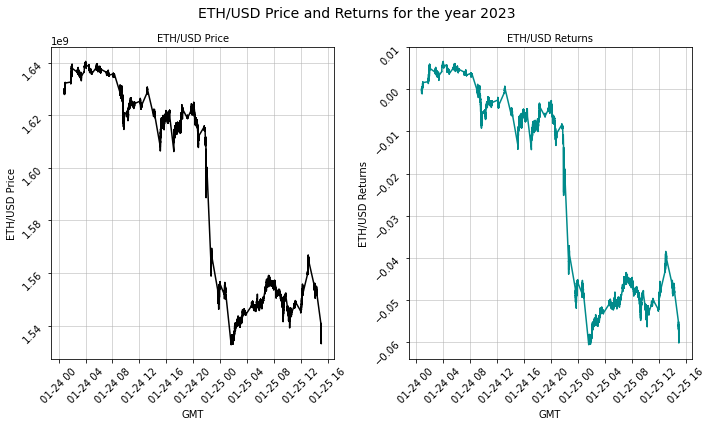

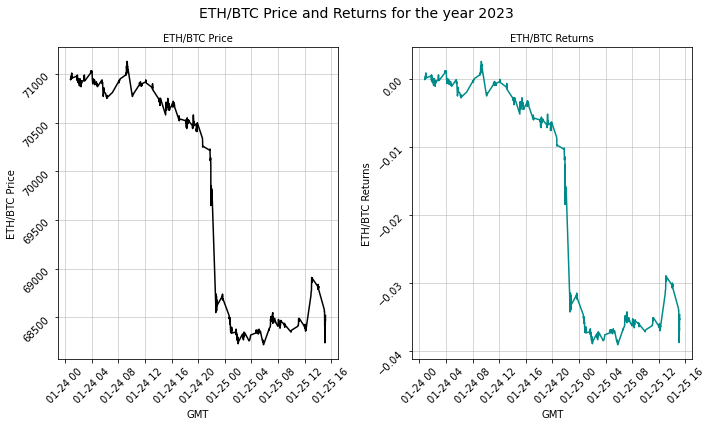

In [325]:
for i in range(3):
    plot_prices(meta_data[i],assets[i],extension = '2023')

<b>Observation</b> From plots above, we can observe that there were sharp price movements in the crypto market returns in the given time period from Jan 23 to Jan 25. There is sharp decline on Jab 25 along with a quick recovery. As seen from all 3 plot pairs of price and returns of 3 crypto time-serieses, it can be concluded that returns are highly correlated, but may not show up in the correlation coefficient calculation because of the Epps Effect.

In [14]:
x1=summaryStats(meta_data[0]).loc['PriceMillionths'].to_frame('BTC/USD')
x2=summaryStats(meta_data[1]).loc['PriceMillionths'].to_frame('ETH/USD')
x3=summaryStats(meta_data[2]).loc['PriceMillionths'].to_frame('ETH/BTC')
x=pd.DataFrame(columns=x1.index)
x=x.append(x1.T)
x=x.append(x2.T)
x=x.append(x3.T)
x

,Period Return,Volatility,Sharpe Ratio,Skewness,Expected Shortfall (95% VaR),Maximum Drawdown
BTC/USD,-0.016561,0.044063,-0.375841,-13.820313,-0.000150,-0.035697
ETH/USD,-0.060025,0.043043,-1.394542,-97.453730,-0.000138,-0.065741
ETH/BTC,-0.034642,0.021177,-1.635792,-20.845474,-0.000895,-0.040911


<b> Observation :</b> From the statistics above, sharpe ratios are negative for all 3 crypto assets. Skewness of each of these serieses is highly negative, indicating heavy left tails.

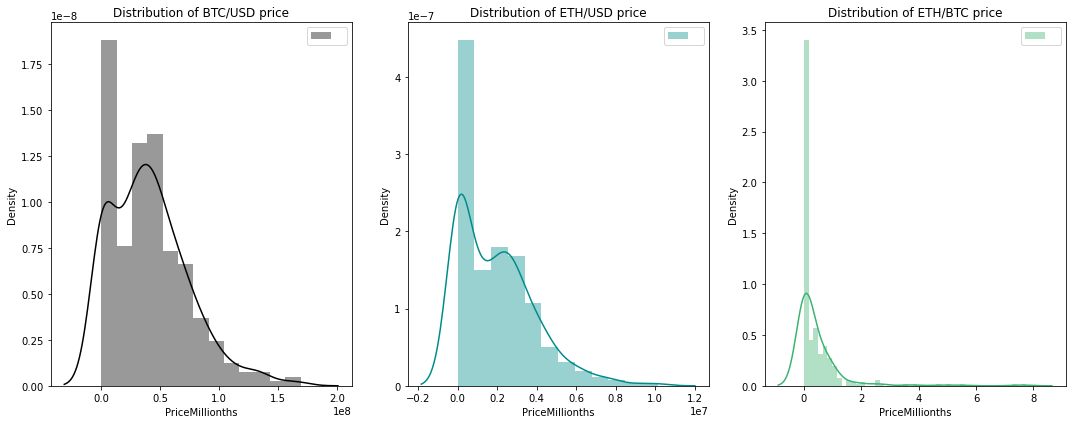

In [489]:
plt.figure(figsize=(15,6))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
colors = [ 'black','darkcyan','mediumseagreen']
for i in range(3):
    plt.subplot(1, 3, i+1)
    df_1min=scale_df_15min(meta_data[i])
    sns.distplot(df_1min['PriceMillionths'], color=colors[i], label=" ")
    plt.legend()
    plt.title(f"Distribution of {assets[i]} price")
plt.tight_layout()
plt.show()
None

<b> Observation :</b> From the displot curves above, it is clear that both BTC/USD and ETH/USD have a bimodal distribution, while ETH/BTC has normal distribution. All three have the commonality that thet are right skewed.

## 4. Single Strategy VWAP Simulator
Here we desribe the results of a single strategy to ensure our model functions correctly and to describe the outputs.
In basecase, we assume the following parameters:
Series= BTC/USD 2023 series\
Side= SELL\
Transaction cost= 0\
Position size = 3.5 bitcoins
Target participation rate= 10%

In the trading algorithm, we build an accumulation engine for buying/selling tokens of crypto with a weighted distribution of target size in upcoming trades to reduce the adverse impact of orders on current price. In order to avoid look-ahead bias and over-estimation of price, we assume worst price possible in a time window of 0.1 seconds to find the transaction cost.

In [273]:
base=simulate_vwap(meta_data[0],3.5,0.1,meta_data[0].iloc[10,0],fees=0, side='sell')

In [274]:
base

,index,Date,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side,volume_traded,cum_trans_cost
0,4,2023-01-24 00:47:55.400,1674521275377409000,22972.31,0.000220,-1,0.000022,0.505023
1,5,2023-01-24 00:47:58.100,1674521278113374000,22971.26,0.002961,-1,0.000296,7.306147
2,6,2023-01-24 00:48:00.200,1674521280210861000,22968.61,0.200000,-1,0.020000,466.678347
3,7,2023-01-24 00:48:03.500,1674521283482084000,22971.27,0.021214,-1,0.002121,515.408726
4,8,2023-01-24 00:48:03.900,1674521283933512000,22969.03,0.150000,-1,0.015000,859.944176
...,...,...,...,...,...,...,...,...
811,815,2023-01-24 01:03:54.000,1674522234000230000,23014.57,0.002173,-1,0.000217,79121.799126
812,816,2023-01-24 01:03:55.300,1674522235311163000,23014.90,0.301000,-1,0.030100,79814.547616
813,817,2023-01-24 01:03:56.700,1674522236715006000,23014.11,0.219462,-1,0.021946,80319.620936
814,818,2023-01-24 01:03:59.800,1674522239795724000,23014.22,0.000652,-1,0.000065,80321.120703


In [299]:
price_summary(base,'BTC/USD')

,BTC/USD prices per unit qty
TWAP,22979.28
VWAP,22979.63
Initial Price,22972.31
Transaction Price,22980.00
Implementation Shortfall,7.69


<b>Observation</b> As seen from the table, we could see that if we start selling BTC with initial price of 22972, we end up completing the transaction to sell 1 bitcoin for an average price of  22959,which is quite close to the Volume weighted Average price.\
For the baseline arrival time, I made a selection based on a visual inspection of the volume chart to cover a period with a total volume close to the median. The total volume over the 15 minute period starting 2023-01-24 00:47, actually is a bit higher than the median at 5e+9 Billionths, but is close enough for illustrative purposes.

Here we see for our baseline parameters on the sell side that our strategy completed in 815 trades over 15 minutes with an implementation shortfall of -$7.69 per unit asset (again, negative indicates shortfall).

# 5. Sensitivities & Comparative Analysis

<b>5.1 Position Size Impact</b>

In [336]:
order_size=[]
for i in range(0,20):
    order_size.append(10**(10-i))
    
order=[]
results=pd.DataFrame()
for i in range(0,20):
    x=price_summary(simulate_vwap(meta_data[0],order_size[i],0.05,meta_data[0].iloc[10,0],fees=0.05, side='sell'),i)
    if i==0:
        results=x
    else:
        results=results.join(x)
results

,0 prices per unit qty,1 prices per unit qty,2 prices per unit qty,3 prices per unit qty,4 prices per unit qty,5 prices per unit qty,6 prices per unit qty,7 prices per unit qty,8 prices per unit qty,9 prices per unit qty,10 prices per unit qty,11 prices per unit qty,12 prices per unit qty,13 prices per unit qty,14 prices per unit qty,15 prices per unit qty,16 prices per unit qty,17 prices per unit qty,18 prices per unit qty,19 prices per unit qty
TWAP,22836.03,22836.03,22836.03,22836.03,22836.03,22836.03,22836.03,22836.03,22972.00,23022.65,22964.13,22964.27,22970.73,22970.73,22971.78,22972.31,22972.31,22972.31,22972.31,22972.31
VWAP,22819.79,22819.79,22819.79,22819.79,22819.79,22819.79,22819.79,22819.79,22964.22,23032.38,22964.67,22963.16,22968.65,22968.65,22971.33,22972.31,22972.31,22972.31,22972.31,22972.31
Initial Price,22972.31,22972.31,22972.31,22972.31,22972.31,22972.31,22972.31,22972.31,22972.31,22972.31,22972.31,22972.31,22972.31,22972.31,22972.31,22972.31,22972.31,22972.31,22972.31,22972.31
Transaction Price,23961.00,23961.00,23961.00,23961.00,23961.00,23961.00,23961.00,23961.00,24112.00,24184.00,24113.00,24112.00,24116.00,24105.00,23994.00,22972.00,22972.00,22972.00,22972.00,22972.00
Implementation Shortfall,988.69,988.69,988.69,988.69,988.69,988.69,988.69,988.69,1139.69,1211.69,1140.69,1139.69,1143.69,1132.69,1021.69,-0.31,-0.31,-0.31,-0.31,-0.31


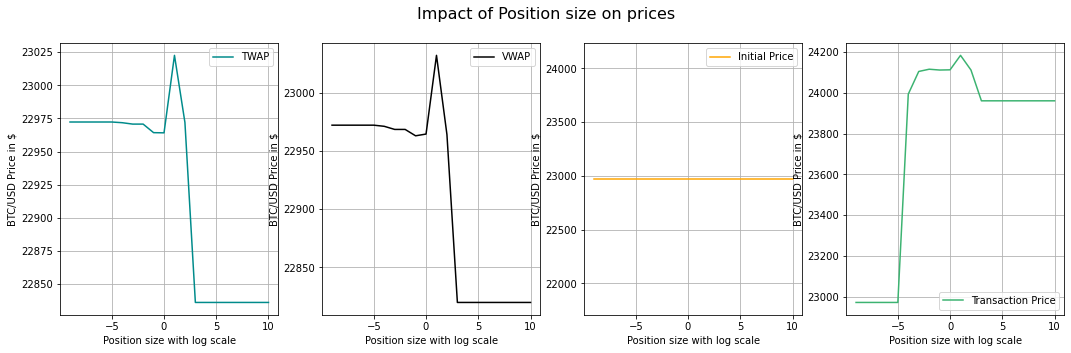

<Figure size 720x432 with 0 Axes>

In [379]:
fig, ax = plt.subplots(1, 4, figsize=(18, 5))
plt.figure(figsize=(10,6))
color=['darkcyan','Black','orange', 'mediumseagreen']
for i in range(4):
    ax[i].plot(np.log10(order_size),results.iloc[i], label = results.index[i],color=color[i])
    ax[i].grid(True)
    ax[i].set(xlabel='Position size with log scale', ylabel='BTC/USD Price in $')
    ax[i].legend(fontsize = 10)
fig.suptitle("Impact of Position size on prices",fontsize = 16)
plt.show()

<b>Observation</b> As seen from the graphs, the transaction price increases as the size increase, but decreases after a certain level and then remain stable. This phenomenon has been explained using power law, specifically the square root law. 

<b> 5.2 Participation rate Impact</b>

In [382]:
tpr = np.arange(0.05,.35, 0.01)
results=pd.DataFrame()
for i in range(0,30):
    x=price_summary(simulate_vwap(meta_data[0],1,tpr[i],meta_data[0].iloc[10,0],fees=0.05, side='sell'),i)
    if i==0:
        results=x
    else:
        results=results.join(x)
results

,0 prices per unit qty,1 prices per unit qty,2 prices per unit qty,3 prices per unit qty,4 prices per unit qty,5 prices per unit qty,6 prices per unit qty,7 prices per unit qty,8 prices per unit qty,9 prices per unit qty,...,20 prices per unit qty,21 prices per unit qty,22 prices per unit qty,23 prices per unit qty,24 prices per unit qty,25 prices per unit qty,26 prices per unit qty,27 prices per unit qty,28 prices per unit qty,29 prices per unit qty
TWAP,22964.13,22962.63,22962.33,22961.55,22960.84,22961.44,22961.67,22962.84,22963.38,22964.17,...,22963.96,22963.77,22963.34,22963.37,22963.40,22963.40,22963.40,22963.40,22963.28,22962.98
VWAP,22964.67,22962.41,22961.66,22960.22,22959.42,22959.37,22960.73,22961.85,22962.40,22962.94,...,22963.47,22962.58,22962.29,22962.29,22962.38,22962.38,22962.36,22962.36,22962.20,22962.06
Initial Price,22972.31,22972.31,22972.31,22972.31,22972.31,22972.31,22972.31,22972.31,22972.31,22972.31,...,22972.31,22972.31,22972.31,22972.31,22972.31,22972.31,22972.31,22972.31,22972.31,22972.31
Transaction Price,24113.00,24111.00,24109.00,24108.00,24107.00,24107.00,24109.00,24110.00,24111.00,24111.00,...,24111.00,24111.00,24110.00,24110.00,24110.00,24110.00,24110.00,24110.00,24110.00,24110.00
Implementation Shortfall,1140.69,1138.69,1136.69,1135.69,1134.69,1134.69,1136.69,1137.69,1138.69,1138.69,...,1138.69,1138.69,1137.69,1137.69,1137.69,1137.69,1137.69,1137.69,1137.69,1137.69


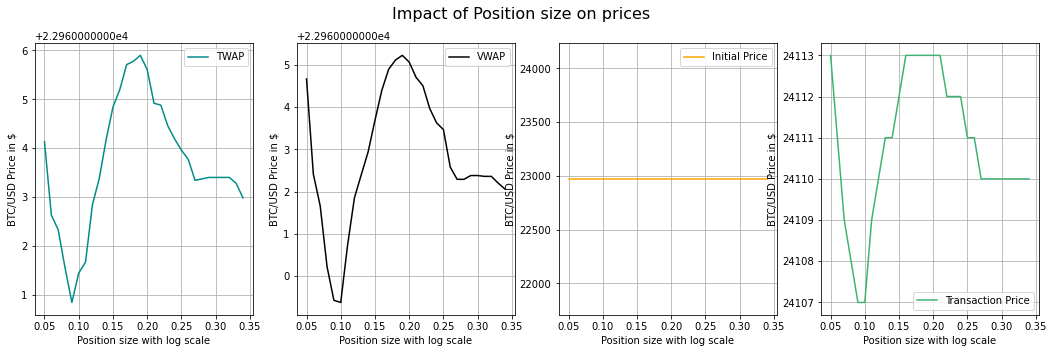

<Figure size 720x432 with 0 Axes>

In [384]:
fig, ax = plt.subplots(1, 4, figsize=(18, 5))
plt.figure(figsize=(10,6))
color=['darkcyan','Black','orange', 'mediumseagreen']
for i in range(4):
    ax[i].plot(tpr,results.iloc[i], label = results.index[i],color=color[i])
    ax[i].grid(True)
    ax[i].set(xlabel='Position size with log scale', ylabel='BTC/USD Price in $')
    ax[i].legend(fontsize = 10)
fig.suptitle("Impact of Position size on prices",fontsize = 16)
plt.show()

<b>Observation</b> As seen from the graphs, as participation rate increases , our transaction cost first goes down and then shoots up to a maximum level before coming down to a stable level. This is straight based on principle of optimal choice, as we could see if we increase participation rate we reach a point where we take all the size available in the first few orders. This showcases that as we increase the rate, we get more greedy.

<b> 5.3 Impact on VWAP </b>

Here, we consider different cases to evaluate impact of VWAP on the accumulation strategy. In first, we take 2 simulations, one buy side and the other sell side, and try to come up with the impact on VWAP

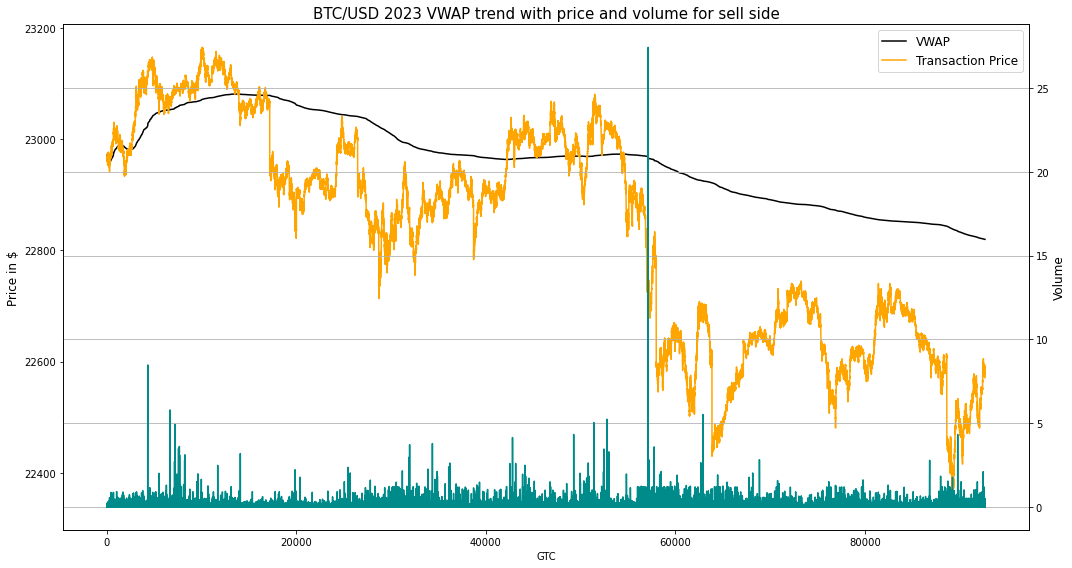

In [451]:
plot_side_vwaps(meta_data[0],'sell')

<b>Observation</b> As can be seen from the plot above, the VWAP does not come down even if the transaction price has reduced to lower levels. This certainly has the impact of volume that has already been build up in the VWAP, and that volume makes it go down at a lower pace than the actual price. This suggests that VWAP has smoother plots and and low volatility in terms of measuring the market beat.

<b> 5.4 Impact of Arrival Time </b>

In [461]:
results=pd.DataFrame()
for i in range(10,501,10):
    x=price_summary(simulate_vwap(meta_data[0],1,0.05,meta_data[0].iloc[i,0],fees=0.05, side='sell'),i)
    if i==10:
        results=x
    else:
        results=results.join(x)
results

,10 prices per unit qty,20 prices per unit qty,30 prices per unit qty,40 prices per unit qty,50 prices per unit qty,60 prices per unit qty,70 prices per unit qty,80 prices per unit qty,90 prices per unit qty,100 prices per unit qty,...,410 prices per unit qty,420 prices per unit qty,430 prices per unit qty,440 prices per unit qty,450 prices per unit qty,460 prices per unit qty,470 prices per unit qty,480 prices per unit qty,490 prices per unit qty,500 prices per unit qty
TWAP,22964.13,22964.13,22964.11,22964.11,22964.09,22964.09,22964.09,22964.08,22964.07,22964.05,...,22964.75,22964.76,22964.77,22964.77,22964.82,22964.89,22964.99,22964.99,22965.01,22965.02
VWAP,22964.67,22964.67,22964.67,22964.67,22964.67,22964.67,22964.67,22964.63,22964.63,22964.59,...,22965.29,22965.29,22965.30,22965.30,22965.35,22965.36,22965.50,22965.50,22965.51,22965.52
Initial Price,22972.31,22972.31,22971.26,22971.26,22968.61,22968.61,22968.61,22971.27,22969.03,22969.46,...,22961.44,22962.61,22962.59,22961.16,22958.80,22959.28,22961.38,22961.38,22959.60,22957.18
Transaction Price,24113.00,24113.00,24112.00,24112.00,24101.00,24101.00,24101.00,24111.00,24104.00,24113.00,...,24113.00,24113.00,24112.00,24105.00,24113.00,24113.00,24114.00,24110.00,24113.00,24097.00
Implementation Shortfall,1140.69,1140.69,1140.74,1140.74,1132.39,1132.39,1132.39,1139.73,1134.97,1143.54,...,1151.56,1150.39,1149.41,1143.84,1154.20,1153.72,1152.62,1148.62,1153.40,1139.82


In [462]:
init1=[x for x in range(10,501,10)]

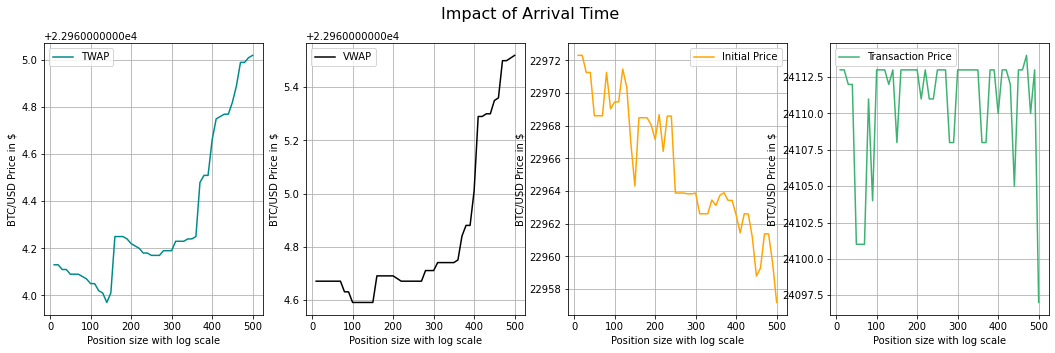

<Figure size 720x432 with 0 Axes>

In [459]:
fig, ax = plt.subplots(1, 4, figsize=(18, 5))
plt.figure(figsize=(10,6))
color=['darkcyan','Black','orange', 'mediumseagreen']
for i in range(4):
    ax[i].plot(init1,results.iloc[i], label = results.index[i],color=color[i])
    ax[i].grid(True)
    ax[i].set(xlabel='Position size with log scale', ylabel='BTC/USD Price in $')
    ax[i].legend(fontsize = 10)
fig.suptitle("Impact of Arrival Time",fontsize = 16)
plt.show()

<b>Observation</b> From the plots above, it is clear that as we go forward in time, our initial price is decreasing, while our VWAP is increasing. This is evident from the fact that in a decreasing price trend, if we are selling shares, it would hurt the overall price if we spread the volume across the order book.

# 6. Conclusion

### Summary
- Volatility and volume have opposite influence on accumulation strategy. The microstructure of trade arrival affects the state of a limit order book
- The arrival time of trades at the near side and the dynamics of the mid-price until the arrival of a trade of a given side depend strongly on the order book imbalance
- The model captures the dependence of trade arrival on order book imbalance, and can therefore be used to construct short-term optimal execution strategies in algorithmic trading


### What are the benefits of the accumulation strategy?

- Speed and Efficiency: The strategy allows for faster execution of trades as compared to manual trading.

- Increased Accuracy: It eliminates the possibility of human error and improves the accuracy of trade execution..

- Increased Liquidity: It helps to provide increased liquidity to financial markets by executing trades faster.

- Better Risk Management: It allows for better risk management by following predetermined rules and conditions for trade execution


### What are the drawbacks of accumulation strategy?
- High maintenance costs: The development and maintenance of systems can be costly, making it difficult for smaller investors to participate. 
- Huge tail risk: there is little in-built loss control, which can lead to quickly compounding losses.
- High trading costs: the frequency of turnover in high percentile positions would generate high trading costs and reduce the overall return
- Data bias and information cost: when assessing a backtest like this, especially in algorithmic trading, it is difficult to avoid lookahead bias. Additionally, if we were to implement this trading strategy, the higher the frequency of the data available, higher the probability of gaps in the series.

### How could we improve this strategy?
Better quality data: In exploratory data analysis, we saw that data has gaps that added noise to our test cases that measure implementation shortfall and time duration from randomly chosen arrival times. Improving the data quality with better frequency would help in better analysis and strategy backtesting.

Variety of crypto assets: Using just 3 test-cases has provided us with a strategy that simplifies actual trading conditions and has myopic view of uncertain factors in the market. Getting tested with different kinds of crypto asset would provide a better testing and validation of the model parameters and output.

